In [1]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

D:\Programmes\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


(1, 784)


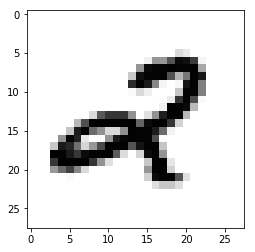

In [4]:
sample_image = mnist.train.next_batch(1)[0]
print(sample_image.shape)

sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image, cmap='Greys')

# Discriminator

In [57]:
def discriminator(images, reuse=False):
    if (reuse):
        tf.get_variable_scope().reuse_variables()

    # First convolutional and pool layers
    # This finds 32 different 5 x 5 pixel features
    d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
    d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
    d1 = d1 + d_b1
    d1 = tf.nn.relu(d1)
    d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Second convolutional and pool layers
    # This finds 64 different 5 x 5 pixel features
    d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
    d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
    d2 = d2 + d_b2
    d2 = tf.nn.relu(d2)
    d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # First fully connected layer
    d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
    d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
    d3 = tf.matmul(d3, d_w3)
    d3 = d3 + d_b3
    d3 = tf.nn.relu(d3)

    # Second fully connected layer
    d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
    d4 = tf.matmul(d3, d_w4) + d_b4

    # d4 contains unscaled values
    return d4

# Generator

In [59]:
def generator(z, batch_size, z_dim):
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)

    # Dimensions of g4: batch_size x 28 x 28 x 1
    return g4

# Parameters

In [50]:
z_dimensions = 100
batch_size = 50

# Test Generator

In [53]:
graph_test = tf.Graph()
with graph_test.as_default():
    z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])
    
with tf.Session(graph=graph_test) as sess:
    generated_image_output = generator(z_placeholder, 1, z_dimensions)
    z_batch = np.random.normal(0, 1, [1, z_dimensions])
    
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output,
                                feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape([28, 28])
    plt.imshow(generated_image, cmap='Greys')

TypeError: generator() missing 1 required positional argument: 'z_dim'

# Training

In [84]:
graph = tf.Graph()
with graph.as_default():
    with tf.variable_scope("GAN", reuse=tf.AUTO_REUSE):
        # tf.get_variable_scope().reuse_variables()
        z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
        # z_placeholder is for feeding input noise to the generator

        x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder') 
        # x_placeholder is for feeding input images to the discriminator

        Gz = generator(z_placeholder, batch_size, z_dimensions) 
        # Gz holds the generated images

        Dx = discriminator(x_placeholder) 
        # Dx will hold discriminator prediction probabilities
        # for the real MNIST images

        Dg = discriminator(Gz)
        # Dg will hold discriminator prediction probabilities for generated images

        # Discriminator Loss
        d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(Dx), logits=Dx))
        d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(Dg), logits=Dg))

        # Generator Loss
        g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(Dg), logits=Dg))

        # Separate trainable variables
        tvars = tf.trainable_variables()

        d_vars = [var for var in tvars if 'd_' in var.name]
        g_vars = [var for var in tvars if 'g_' in var.name]

        print([v.name for v in d_vars])
        print([v.name for v in g_vars])

        # Train the discriminator
        d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
        d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

        # Train the generator
        g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)
        
        visualization_generator = generator(z_placeholder, batch_size, z_dimensions)
        visualization_discriminator = discriminator(x_placeholder)
        
        ################" TENSORBOARD #################
        tf.summary.scalar('Generator_loss', g_loss)
        tf.summary.scalar('Discriminator_loss_real', d_loss_real)
        tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

        tf.summary.image('Generated_images', visualization_generator, 5)
        merged = tf.summary.merge_all()

['GAN/d_w1:0', 'GAN/d_b1:0', 'GAN/d_w2:0', 'GAN/d_b2:0', 'GAN/d_w3:0', 'GAN/d_b3:0', 'GAN/d_w4:0', 'GAN/d_b4:0']
['GAN/g_w1:0', 'GAN/g_b1:0', 'GAN/g_w2:0', 'GAN/g_b2:0', 'GAN/g_w3:0', 'GAN/g_b3:0', 'GAN/g_w4:0', 'GAN/g_b4:0']


dLossReal: 0.69296294 dLossFake: 0.6949884
dLossReal: 0.015233389 dLossFake: 0.02600267
dLossReal: 0.0023787594 dLossFake: 0.0031932413
Iteration: 0 at 2018-03-03 02:20:13.788931


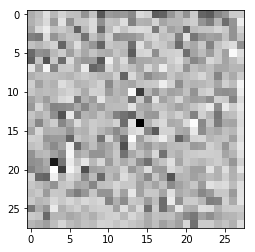

Estimate: [[-6.4301696]]
Iteration: 100 at 2018-03-03 02:20:45.579119


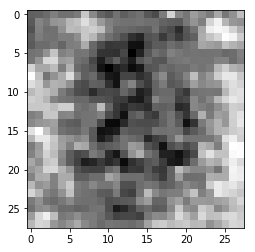

Estimate: [[-6.9856896]]
Iteration: 200 at 2018-03-03 02:21:17.370189


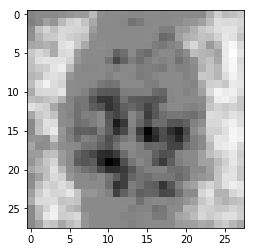

Estimate: [[-6.7550354]]
Iteration: 300 at 2018-03-03 02:21:49.157837


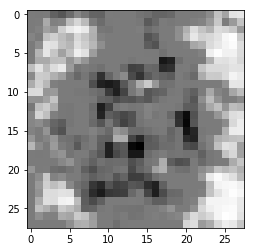

Estimate: [[-12.4227915]]
Iteration: 400 at 2018-03-03 02:22:20.880451


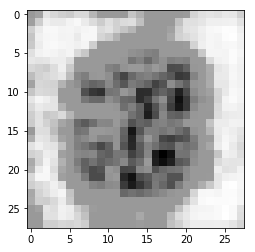

Estimate: [[-14.302146]]
Iteration: 500 at 2018-03-03 02:22:52.589057


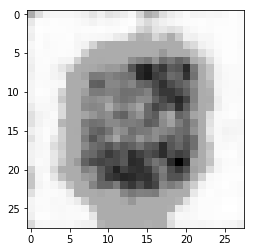

Estimate: [[-12.101074]]
Iteration: 600 at 2018-03-03 02:23:24.321452


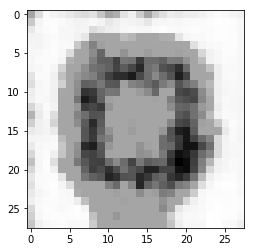

Estimate: [[-10.458312]]
Iteration: 700 at 2018-03-03 02:23:56.105842


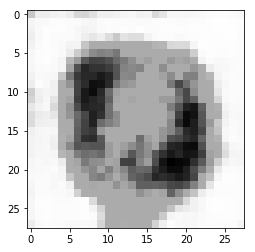

Estimate: [[-11.176654]]
Iteration: 800 at 2018-03-03 02:24:27.829933


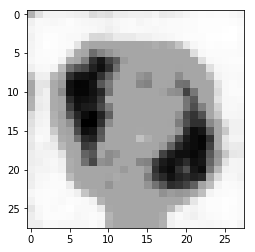

Estimate: [[-10.234189]]
Iteration: 900 at 2018-03-03 02:24:59.642652


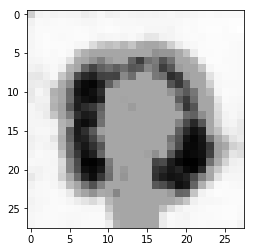

Estimate: [[-6.072361]]
Iteration: 1000 at 2018-03-03 02:25:31.346917


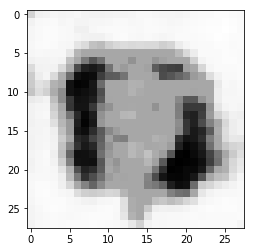

Estimate: [[-7.977088]]
Iteration: 1100 at 2018-03-03 02:26:03.283095


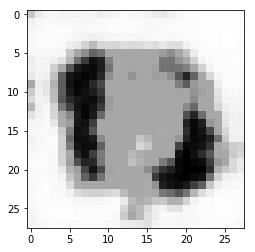

Estimate: [[-8.04086]]
Iteration: 1200 at 2018-03-03 02:26:35.054077


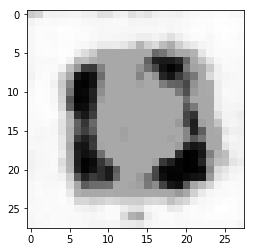

Estimate: [[1.3325322]]
Iteration: 1300 at 2018-03-03 02:27:06.976419


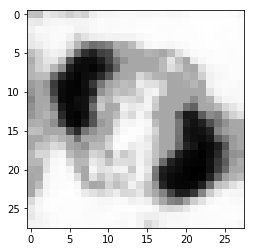

Estimate: [[-4.503027]]
Iteration: 1400 at 2018-03-03 02:27:38.692608


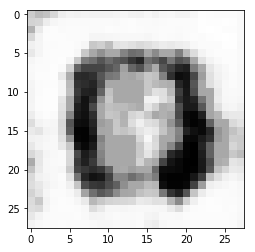

Estimate: [[-5.7987237]]
Iteration: 1500 at 2018-03-03 02:28:10.470348


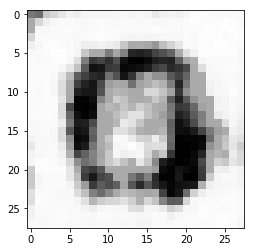

Estimate: [[-12.579231]]
Iteration: 1600 at 2018-03-03 02:28:42.231959


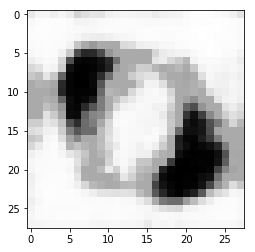

Estimate: [[-9.9100485]]
Iteration: 1700 at 2018-03-03 02:29:14.053390


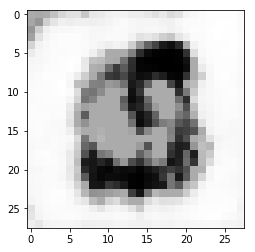

Estimate: [[-0.6704563]]
Iteration: 1800 at 2018-03-03 02:29:45.773643


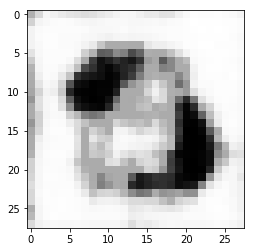

Estimate: [[-4.2581635]]
Iteration: 1900 at 2018-03-03 02:30:17.494178


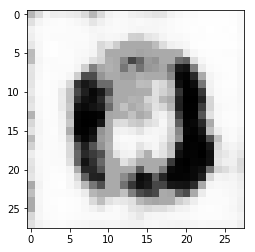

Estimate: [[-5.0182056]]
Iteration: 2000 at 2018-03-03 02:30:49.196127


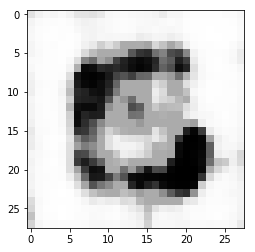

Estimate: [[-3.8377998]]
Iteration: 2100 at 2018-03-03 02:31:20.915963


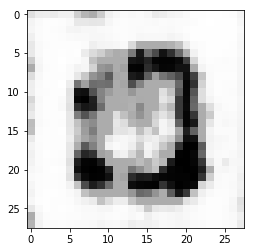

Estimate: [[-5.510621]]
Iteration: 2200 at 2018-03-03 02:31:52.641217


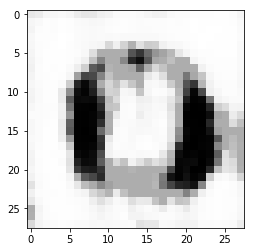

Estimate: [[-3.6097782]]
Iteration: 2300 at 2018-03-03 02:32:24.409573


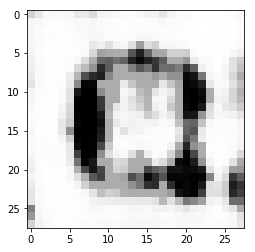

Estimate: [[-3.2366247]]
Iteration: 2400 at 2018-03-03 02:32:56.272374


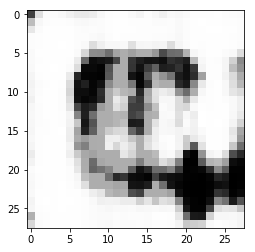

Estimate: [[-3.4517176]]
Iteration: 2500 at 2018-03-03 02:33:28.003501


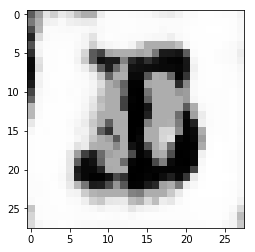

Estimate: [[-5.9558363]]
Iteration: 2600 at 2018-03-03 02:33:59.765587


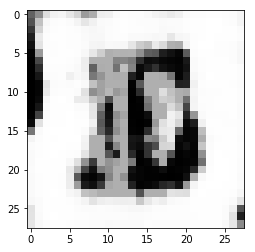

Estimate: [[-4.31188]]
Iteration: 2700 at 2018-03-03 02:34:31.514525


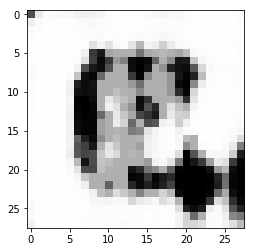

Estimate: [[6.9288816]]
Iteration: 2800 at 2018-03-03 02:35:03.264993


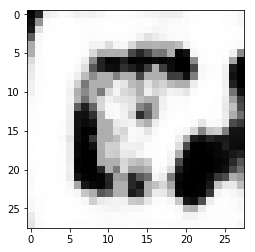

Estimate: [[-2.2205284]]
Iteration: 2900 at 2018-03-03 02:35:35.012335


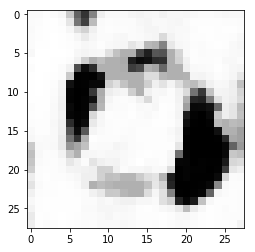

Estimate: [[-8.951619]]
Iteration: 3000 at 2018-03-03 02:36:06.722005


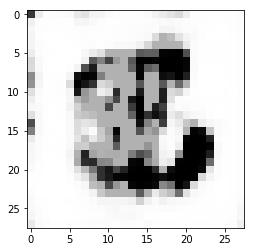

Estimate: [[-8.195612]]
Iteration: 3100 at 2018-03-03 02:36:38.481180


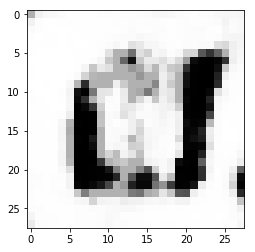

Estimate: [[-4.095383]]
Iteration: 3200 at 2018-03-03 02:37:10.254752


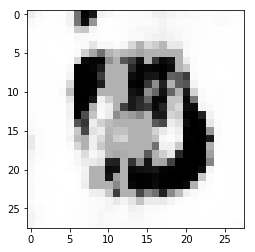

Estimate: [[-4.688843]]
Iteration: 3300 at 2018-03-03 02:37:42.149746


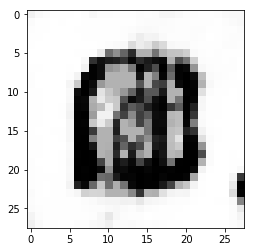

Estimate: [[-3.9012988]]
Iteration: 3400 at 2018-03-03 02:38:13.991876


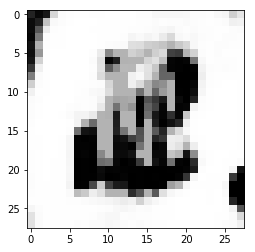

Estimate: [[-3.6212404]]
Iteration: 3500 at 2018-03-03 02:38:46.012818


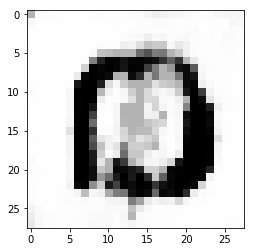

Estimate: [[1.2378987]]
Iteration: 3600 at 2018-03-03 02:39:17.888272


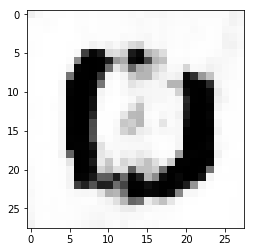

Estimate: [[-8.199253]]
Iteration: 3700 at 2018-03-03 02:39:49.770592


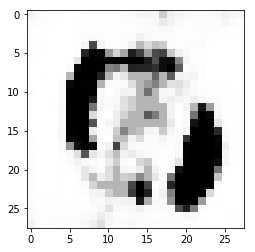

Estimate: [[1.433423]]
Iteration: 3800 at 2018-03-03 02:40:21.566075


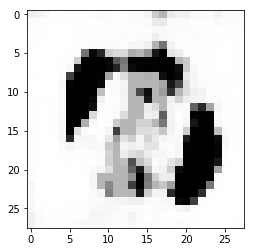

Estimate: [[-7.2157974]]
Iteration: 3900 at 2018-03-03 02:40:53.434121


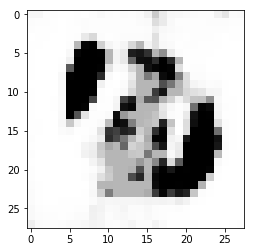

Estimate: [[-3.9995322]]
Iteration: 4000 at 2018-03-03 02:41:25.264316


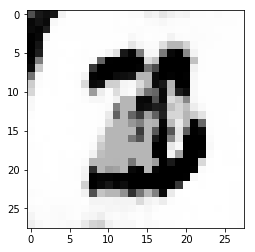

Estimate: [[-8.3579]]
Iteration: 4100 at 2018-03-03 02:41:57.228634


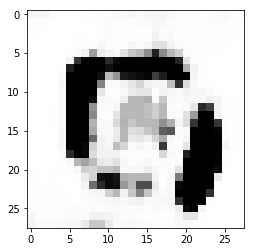

Estimate: [[-5.4696045]]
Iteration: 4200 at 2018-03-03 02:42:29.165041


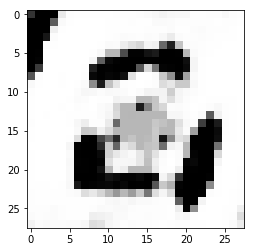

Estimate: [[-4.5462666]]
Iteration: 4300 at 2018-03-03 02:43:01.062791


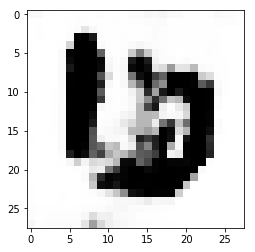

Estimate: [[-0.47088367]]
Iteration: 4400 at 2018-03-03 02:43:32.869388


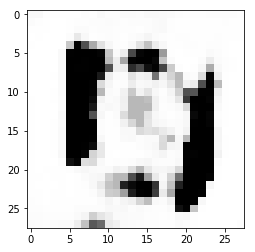

Estimate: [[0.33653525]]
Iteration: 4500 at 2018-03-03 02:44:04.719361


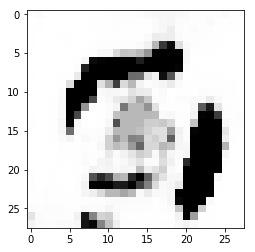

Estimate: [[-3.2164648]]
Iteration: 4600 at 2018-03-03 02:44:36.674589


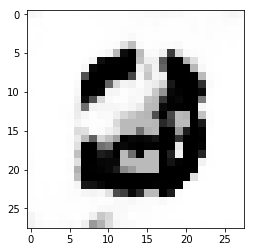

Estimate: [[-7.7113166]]
Iteration: 4700 at 2018-03-03 02:45:08.503369


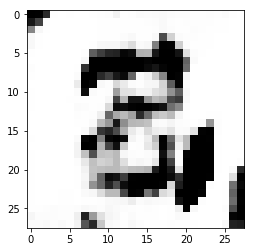

Estimate: [[-4.6360707]]
Iteration: 4800 at 2018-03-03 02:45:40.364943


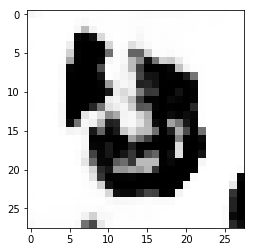

Estimate: [[-7.4425974]]
Iteration: 4900 at 2018-03-03 02:46:12.230860


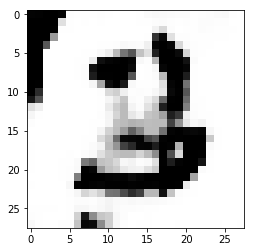

Estimate: [[0.9075783]]
Iteration: 5000 at 2018-03-03 02:46:44.081858


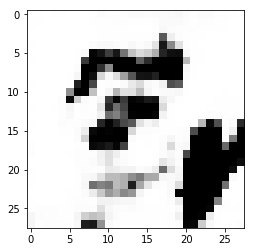

Estimate: [[2.1282704]]
Iteration: 5100 at 2018-03-03 02:47:15.936161


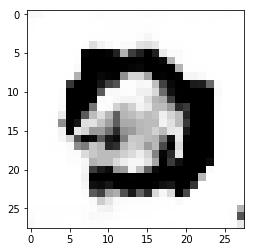

Estimate: [[-11.789503]]
Iteration: 5200 at 2018-03-03 02:47:47.818475


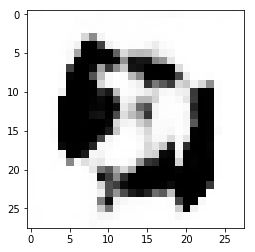

Estimate: [[-14.960977]]
Iteration: 5300 at 2018-03-03 02:48:19.652808


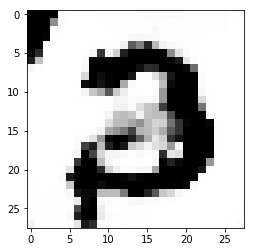

Estimate: [[-9.672222]]
Iteration: 5400 at 2018-03-03 02:48:51.481199


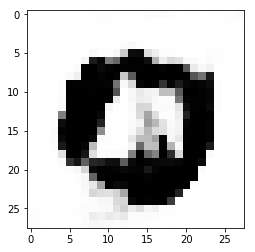

Estimate: [[-3.497694]]
Iteration: 5500 at 2018-03-03 02:49:23.309442


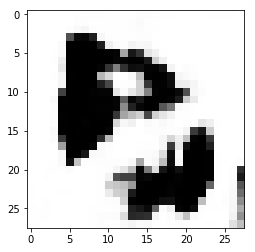

Estimate: [[-9.179934]]
Iteration: 5600 at 2018-03-03 02:49:55.196728


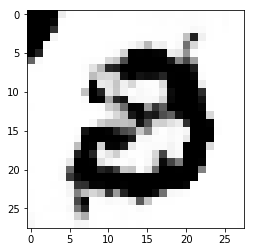

Estimate: [[-5.7132397]]
Iteration: 5700 at 2018-03-03 02:50:27.234279


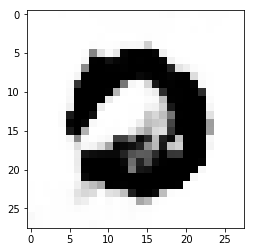

Estimate: [[-8.659347]]
Iteration: 5800 at 2018-03-03 02:50:59.099472


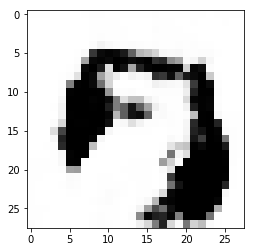

Estimate: [[-2.0763817]]
Iteration: 5900 at 2018-03-03 02:51:30.949226


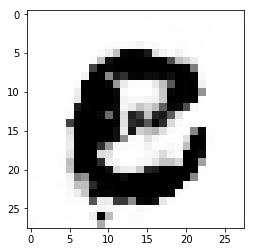

Estimate: [[-8.681229]]
Iteration: 6000 at 2018-03-03 02:52:02.919699


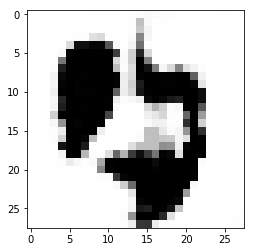

Estimate: [[-4.0443325]]
Iteration: 6100 at 2018-03-03 02:52:34.750353


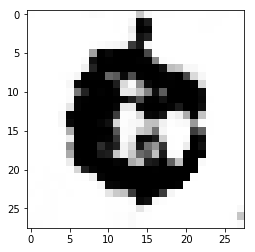

Estimate: [[-1.0577129]]
Iteration: 6200 at 2018-03-03 02:53:06.591809


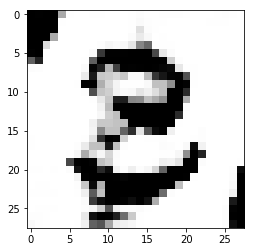

Estimate: [[-6.2458634]]
Iteration: 6300 at 2018-03-03 02:53:38.472640


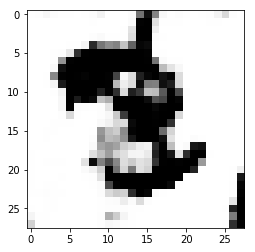

Estimate: [[-10.084464]]
Iteration: 6400 at 2018-03-03 02:54:10.355549


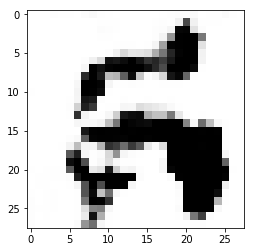

Estimate: [[-1.8485887]]
Iteration: 6500 at 2018-03-03 02:54:42.238427


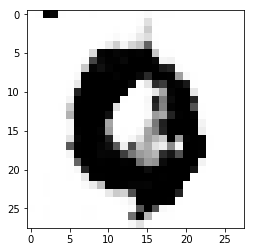

Estimate: [[0.9234351]]
Iteration: 6600 at 2018-03-03 02:55:14.117122


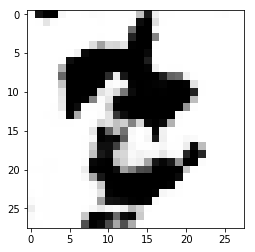

Estimate: [[-1.1700927]]
Iteration: 6700 at 2018-03-03 02:55:46.014162


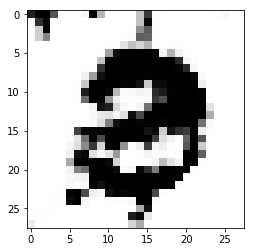

Estimate: [[-11.20472]]
Iteration: 6800 at 2018-03-03 02:56:18.045132


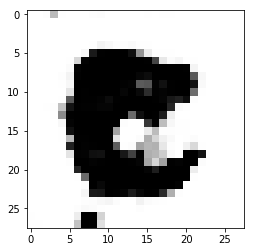

Estimate: [[2.7770221]]
Iteration: 6900 at 2018-03-03 02:56:49.946030


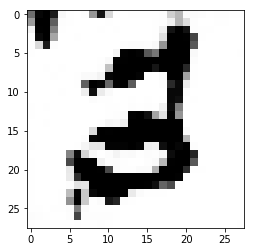

Estimate: [[-8.544015]]
Iteration: 7000 at 2018-03-03 02:57:21.793206


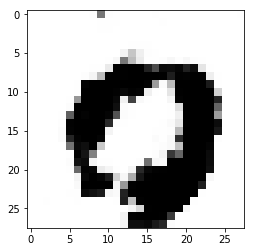

Estimate: [[6.8785734]]
Iteration: 7100 at 2018-03-03 02:57:53.674522


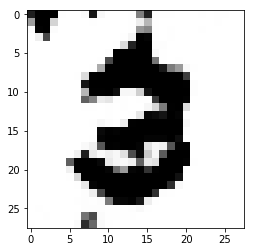

Estimate: [[-11.918313]]
Iteration: 7200 at 2018-03-03 02:58:25.491319


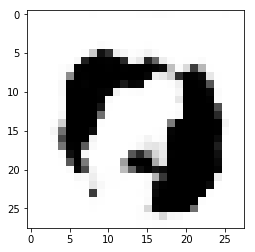

Estimate: [[-0.8876577]]
Iteration: 7300 at 2018-03-03 02:58:57.592440


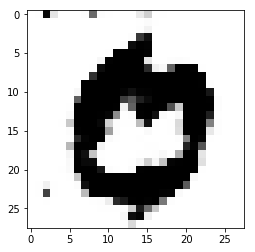

Estimate: [[-8.850273]]
Iteration: 7400 at 2018-03-03 02:59:29.584061


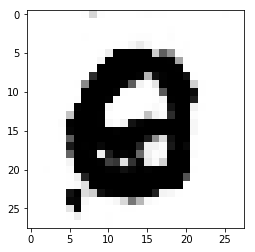

Estimate: [[-5.465198]]
Iteration: 7500 at 2018-03-03 03:00:01.450517


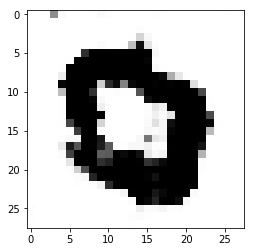

Estimate: [[-3.5773268]]
Iteration: 7600 at 2018-03-03 03:00:33.342367


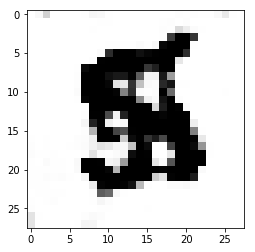

Estimate: [[-3.0025737]]
Iteration: 7700 at 2018-03-03 03:01:05.390991


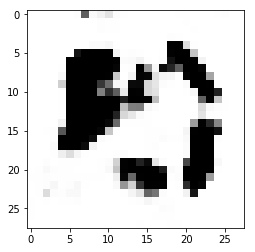

Estimate: [[0.57581794]]
Iteration: 7800 at 2018-03-03 03:01:37.318336


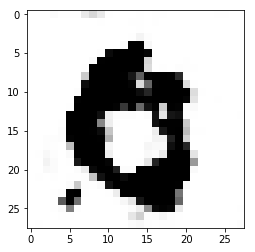

Estimate: [[-8.6184]]
Iteration: 7900 at 2018-03-03 03:02:09.371585


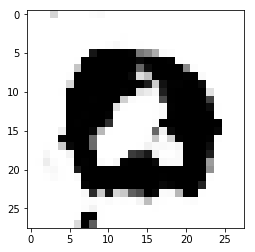

Estimate: [[1.1397234]]
Iteration: 8000 at 2018-03-03 03:02:41.232497


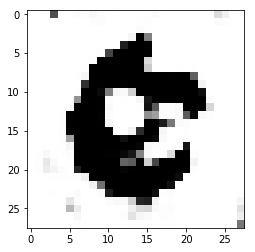

Estimate: [[-0.9175835]]
Iteration: 8100 at 2018-03-03 03:03:13.094631


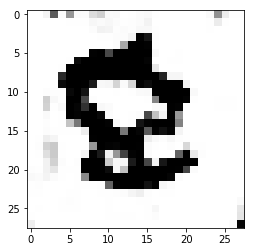

Estimate: [[-4.738865]]
Iteration: 8200 at 2018-03-03 03:03:45.065624


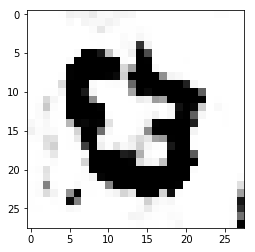

Estimate: [[-5.0080957]]
Iteration: 8300 at 2018-03-03 03:04:16.988162


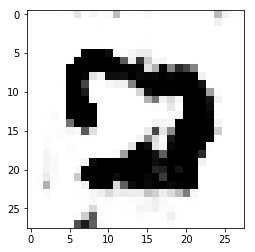

Estimate: [[-9.857]]
Iteration: 8400 at 2018-03-03 03:04:48.837915


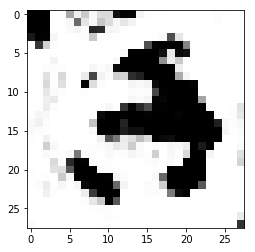

Estimate: [[-4.686956]]
Iteration: 8500 at 2018-03-03 03:05:20.673069


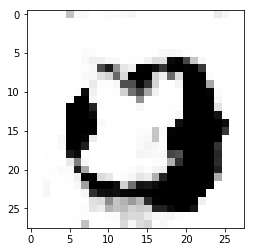

Estimate: [[-0.7580093]]
Iteration: 8600 at 2018-03-03 03:05:52.516692


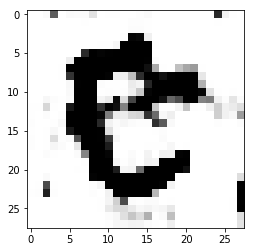

Estimate: [[-7.4983625]]
Iteration: 8700 at 2018-03-03 03:06:24.494774


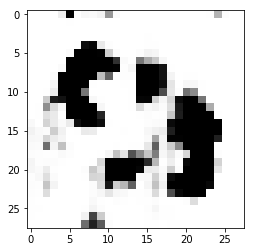

Estimate: [[-3.7008803]]
Iteration: 8800 at 2018-03-03 03:06:56.379567


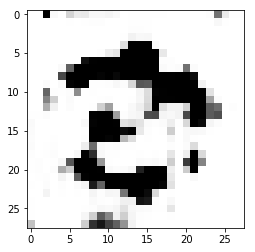

Estimate: [[-4.439224]]
Iteration: 8900 at 2018-03-03 03:07:28.230917


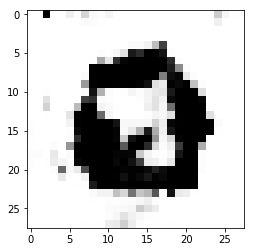

Estimate: [[-2.445497]]
Iteration: 9000 at 2018-03-03 03:08:00.241096


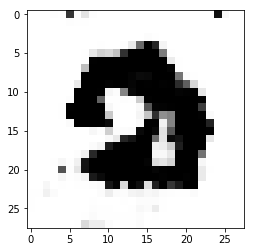

Estimate: [[-4.9103694]]
Iteration: 9100 at 2018-03-03 03:08:32.136446


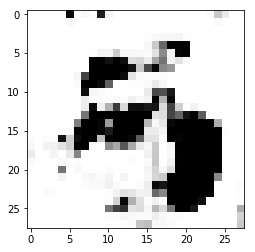

Estimate: [[-4.372717]]
Iteration: 9200 at 2018-03-03 03:09:04.089998


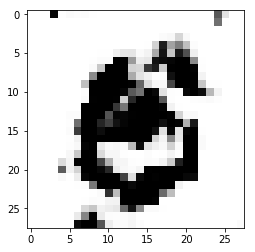

Estimate: [[-3.303443]]
Iteration: 9300 at 2018-03-03 03:09:36.013535


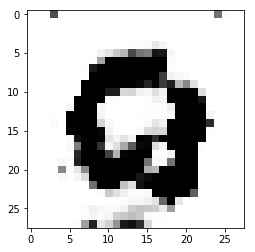

Estimate: [[1.8109413]]
Iteration: 9400 at 2018-03-03 03:10:07.942498


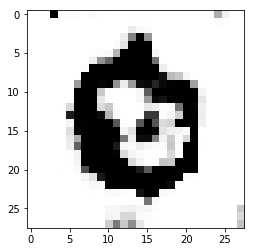

Estimate: [[-2.8753235]]
Iteration: 9500 at 2018-03-03 03:10:39.793210


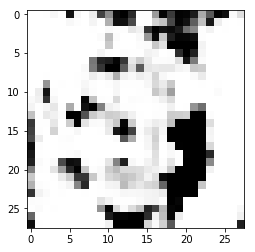

Estimate: [[-8.3514]]
Iteration: 9600 at 2018-03-03 03:11:11.648172


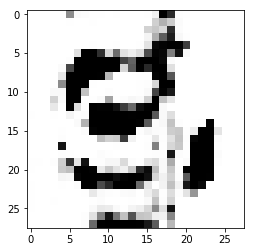

Estimate: [[-2.741442]]
Iteration: 9700 at 2018-03-03 03:11:43.547957


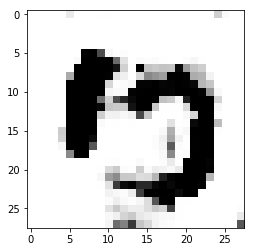

Estimate: [[-1.3130434]]


KeyboardInterrupt: 

In [85]:
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, graph)


with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())

    # Pre-train discriminator
    for i in range(300):
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
        _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                               {x_placeholder: real_image_batch, z_placeholder: z_batch})

        if(i % 100 == 0):
            print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

    # Train generator and discriminator together
    for i in range(100000):
        real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

        # Train discriminator on both real and fake images
        _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                               {x_placeholder: real_image_batch, z_placeholder: z_batch})

        # Train generator
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})

        if i % 10 == 0:
            # Update TensorBoard with summary statistics
            z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
            summary = sess.run(merged, {z_placeholder: z_batch, x_placeholder: real_image_batch})
            writer.add_summary(summary, i)

        if i % 100 == 0:
            # Every 100 iterations, show a generated image
            print("Iteration:", i, "at", datetime.datetime.now())
            z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
#             generated_images = generator(z_placeholder, 1, z_dimensions)
            images = sess.run(visualization_generator, {z_placeholder: z_batch})
            plt.imshow(images[0].reshape([28, 28]), cmap='Greys')
            plt.show()

            # Show discriminator's estimate
            im = images[0].reshape([1, 28, 28, 1])
#             result = discriminator(x_placeholder)
            estimate = sess.run(visualization_discriminator, {x_placeholder: im})
            print("Estimate:", estimate)